In [21]:
#  Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('/kaggle/input/stock-trading-app-reviews-zerodha-groww-etc/Stock_Trading_App_Reviews.csv')

In [3]:
df.head()

,reviewId,content,score,app
0,be071c83-6d3c-4db3-94c0-2714c04fc47d,good app,4,Zerodha (Kite)
1,aedd0c3c-69ef-4088-813f-df473e00ef0f,good,5,Zerodha (Kite)
2,994812ae-8110-47e4-9e8f-6dba21dc37f8,nice app better than angelone in terms of brok...,5,Zerodha (Kite)
3,e15872b4-b646-4878-b35e-d26527379bec,good,5,Zerodha (Kite)
4,20237158-d654-4796-84c4-e809c7034de7,happy with customer service,5,Zerodha (Kite)


# Missing Values Analysis 

In [4]:
df.isnull().sum()

reviewId    0
content     2
score       0
app         0
dtype: int64

The dataset is mostly complete, with only 2 missing entries in the content column. All other columns (reviewId, score, app) have no missing values. Since content is essential for analysis, rows with missing values in this column will be removed to ensure data quality.

In [5]:
df.dropna(subset='content', inplace=True)

# Sentiment Label Creation

In [6]:
df['sentiment'] = df['score'].apply(lambda x: 'positive' if x >= 4 else ( 'negative' if x <= 2 else 'neutral'))

To prepare the data for sentiment analysis, a new column sentiment is created based on the review score.

* Reviews with a score ≥ 4 are labeled as positive.

* Reviews with a score ≤ 2 are labeled as negative.

* Reviews with a score of 3 are labeled as neutral.

This step converts numeric ratings into categorical sentiment labels, which will be useful for training and evaluating machine learning models.

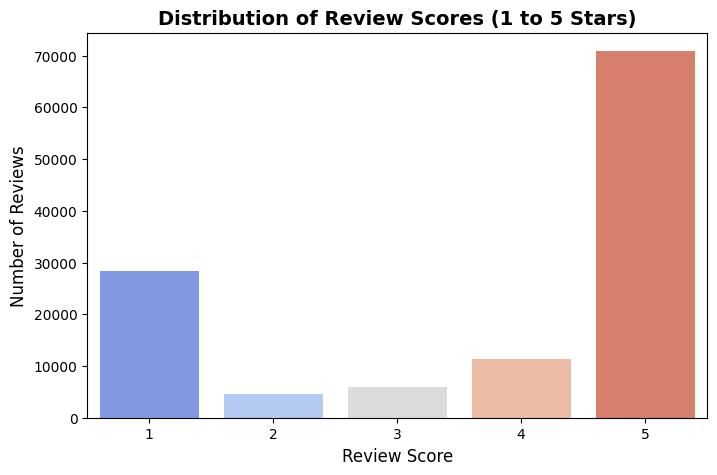

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df, 
    x='score', 
    order=sorted(df['score'].unique()), 
    palette='coolwarm'
)

plt.title("Distribution of Review Scores (1 to 5 Stars)", fontsize=14, weight='bold')
plt.xlabel("Review Score", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.show()


**Review Score Distribution**

The bar chart shows the distribution of user ratings from 1 to 5 stars.

* The height of each bar represents how many users gave that rating.

* This helps identify whether the majority of users provide positive, neutral, or negative feedback, giving an initial indication of overall app satisfaction.

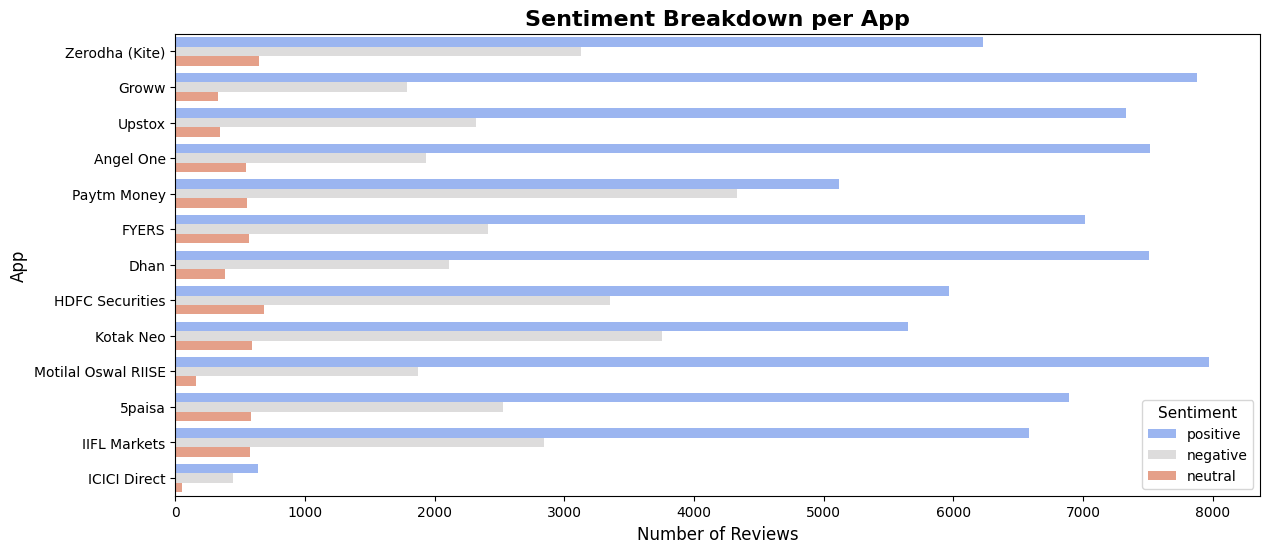

In [8]:
# 2. Sentiment count per app
# 2. Sentiment count per app
plt.figure(figsize=(14,6))
sns.countplot(
    data=df,
    y='app',
    hue='sentiment',
    order=df['app'].value_counts().index,
    palette='coolwarm'   # smooth, modern color palette
)

plt.title("Sentiment Breakdown per App", fontsize=16, weight='bold')
plt.xlabel("Number of Reviews", fontsize=12)
plt.ylabel("App", fontsize=12)
plt.legend(title='Sentiment', fontsize=10, title_fontsize=11)
plt.show()



**Sentiment Breakdown per App**

This chart illustrates how user sentiment varies across different apps.

* Each horizontal bar shows the number of reviews per app, broken down into positive, neutral, and negative sentiment categories.

* This comparison helps identify which apps have the most favorable perception and which receive more critical feedback.

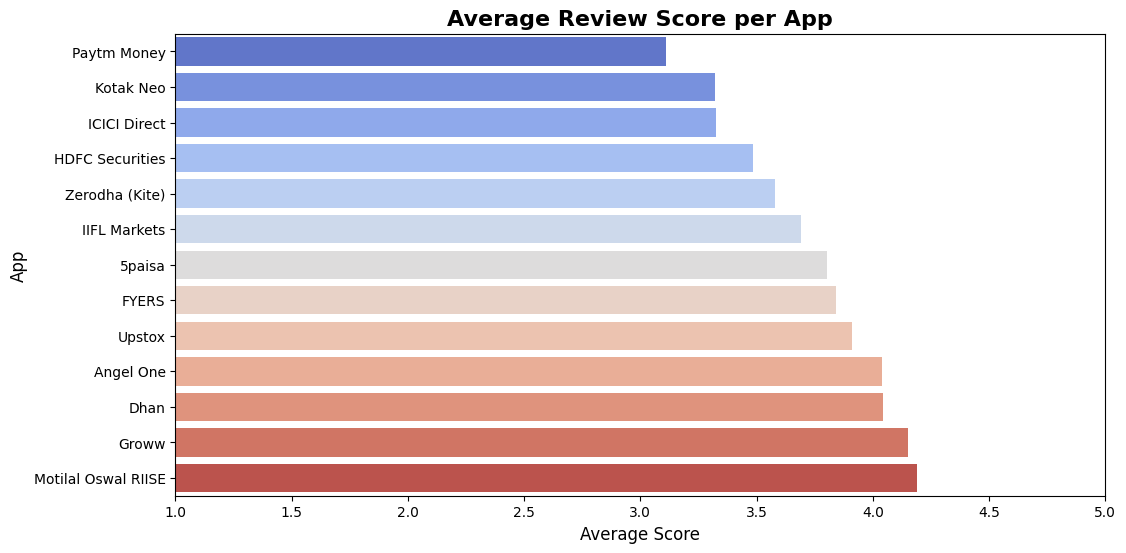

In [25]:
# 3. Average score per app
avg_scores = df.groupby("app")["score"].mean().sort_values()

plt.figure(figsize=(12,6))
ax = sns.barplot(
    x=avg_scores.values, 
    y=avg_scores.index, 
    palette="coolwarm"
)


plt.title("Average Review Score per App", fontsize=16, weight='bold')
plt.xlabel("Average Score", fontsize=12)
plt.ylabel("App", fontsize=12)
plt.xlim(1, 5)
plt.show()


**Average Review Score per App**

The chart shows the average rating (1–5 stars) for each app.

* Apps on the lower end (closer to 1) indicate poorer user satisfaction, while those closer to 5 reflect highly positive feedback.

* Adding score labels makes it easy to see exact averages, enabling a clear comparison of app performance based on user reviews.

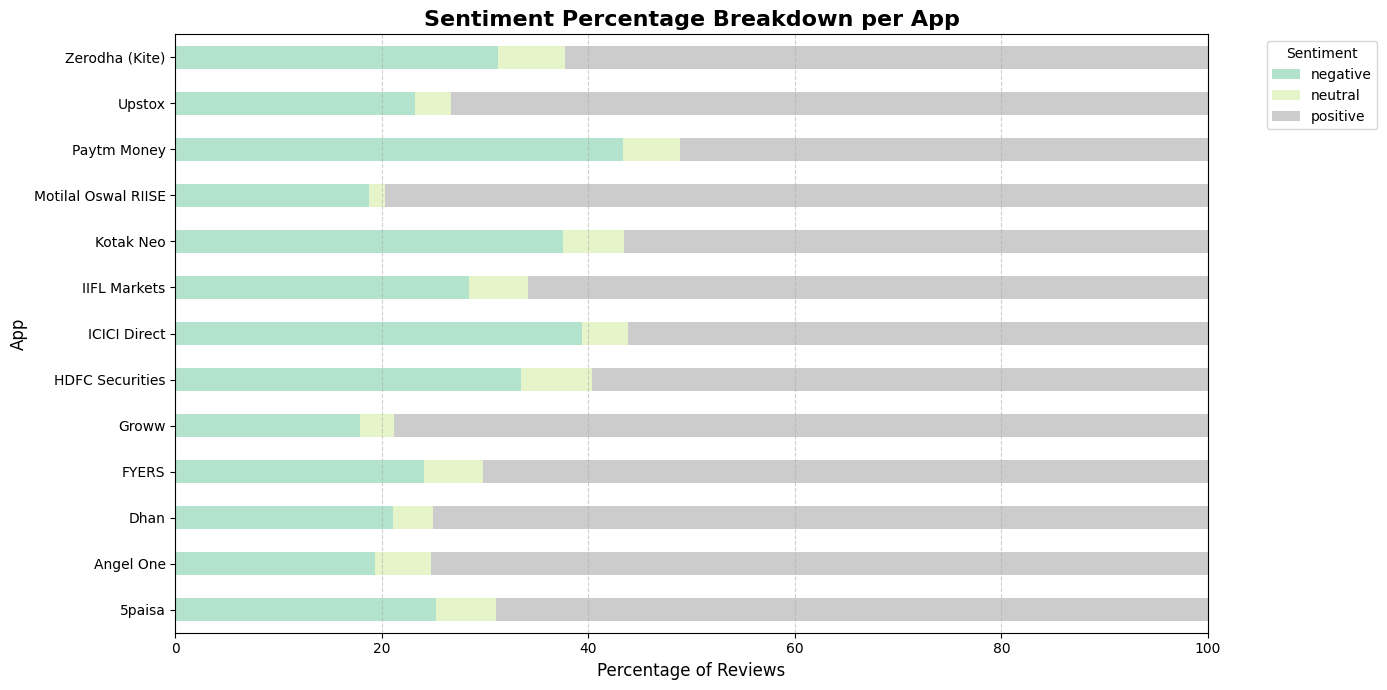

In [10]:
sentiment_ratio = df.groupby(['app', 'sentiment']).size().unstack().fillna(0)
sentiment_percent = sentiment_ratio.div(sentiment_ratio.sum(axis=1), axis=0) * 100

sentiment_percent.plot(
    kind='barh',
    stacked=True,
    figsize=(14,7),
    colormap='Pastel2'
)

plt.title("Sentiment Percentage Breakdown per App", fontsize=16, weight='bold')
plt.xlabel("Percentage of Reviews", fontsize=12)
plt.ylabel("App", fontsize=12)
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Sentiment Percentage Breakdown per App**

This chart displays the relative proportion of positive, neutral, and negative reviews for each app using a soft color palette for clarity.

* By normalizing review counts into percentages, we can directly compare apps regardless of how many reviews they received.

* A higher proportion of light green/blue shades reflects stronger positive sentiment, while larger shares of pink/purple shades indicate neutral or negative sentiment.

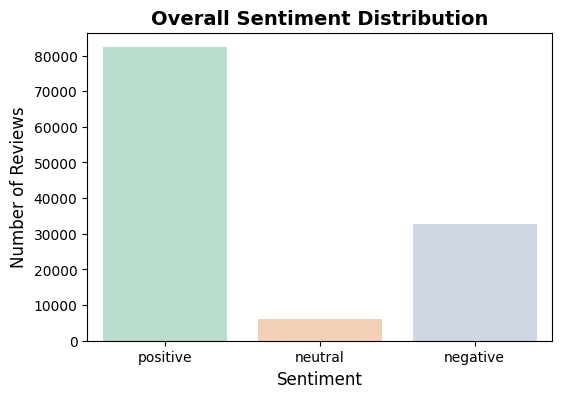

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df, 
    x='sentiment', 
    order=['positive', 'neutral', 'negative'], 
    palette='Pastel2'
)

plt.title("Overall Sentiment Distribution", fontsize=14, weight='bold')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.show()


**Overall Sentiment Distribution**

This chart shows the overall balance of positive, neutral, and negative reviews across all apps.

* The height of each bar represents the total number of reviews in that sentiment category.

* This provides a quick snapshot of general user perception, indicating whether reviews lean more toward satisfaction or dissatisfaction.

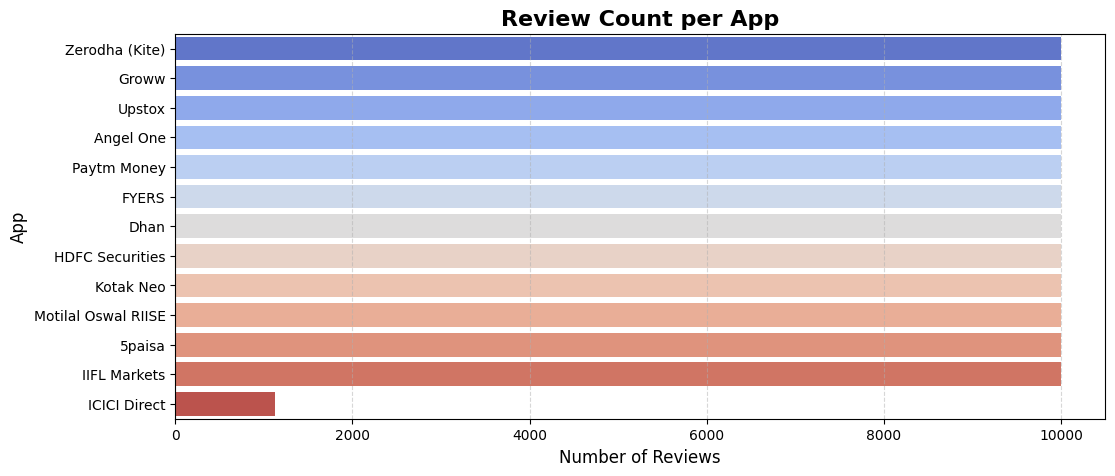

In [12]:
plt.figure(figsize=(12,5))
sns.countplot(
    data=df,
    y='app',
    order=df['app'].value_counts().index,
    palette="coolwarm"
)

plt.title("Review Count per App", fontsize=16, weight='bold')
plt.xlabel("Number of Reviews", fontsize=12)
plt.ylabel("App", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


**Distribution of Reviews per App**

The chart displays the number of reviews received by each app.

* Apps at the top of the list have the highest number of reviews, while those lower down have fewer.

* This provides insight into user engagement levels, showing which apps attract the most feedback from users.

In [27]:
pos_text = " ".join(df[df.sentiment=="positive"]["content"].dropna())
neg_text = " ".join(df[df.sentiment=="negative"]["content"].dropna())

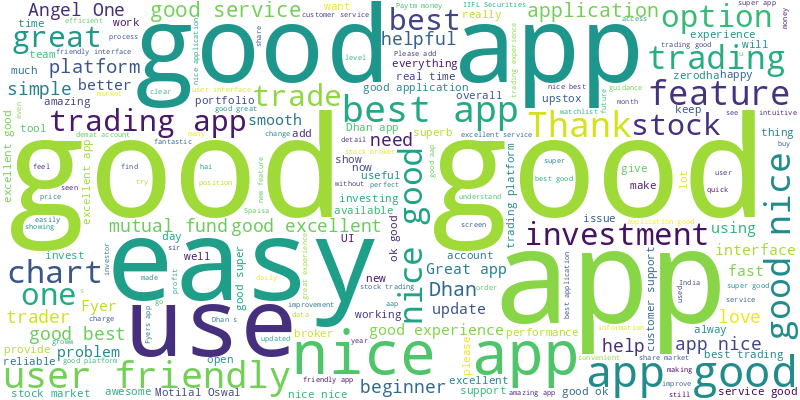

In [30]:
from wordcloud import WordCloud
WordCloud(width=800, height=400, background_color="white").generate(pos_text).to_image()

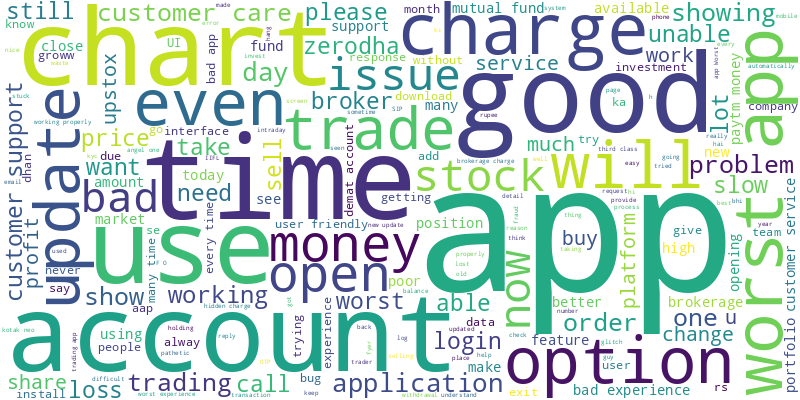

In [32]:
WordCloud(width=800, height=400, background_color="white").generate(neg_text).to_image()

In [15]:
# --- 5. Prepare Data for Modeling ---
# Drop neutral for binary classification
df_bin = df[df["sentiment"] != "neutral"].copy()

# Define X and y
X = df_bin["content"]
y = df_bin["sentiment"].map({"positive": 1, "negative": 0})

# Vectorize
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_vec = vectorizer.fit_transform(X)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
# --- 6. Define Evaluation Function ---
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n📊 {model_name} Results:\n")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


📊 Logistic Regression Results:

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      6565
           1       0.93      0.96      0.94     16457

    accuracy                           0.92     23022
   macro avg       0.91      0.89      0.90     23022
weighted avg       0.92      0.92      0.92     23022



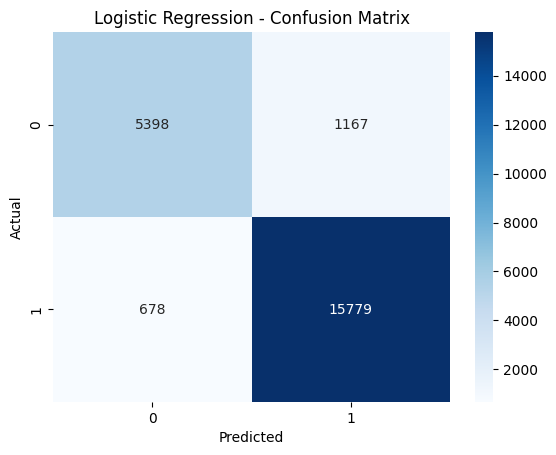

In [17]:
# --- 7. Train & Evaluate Models ---
# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test, "Logistic Regression")



📊 Linear SVM Results:

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      6565
           1       0.93      0.96      0.94     16457

    accuracy                           0.92     23022
   macro avg       0.91      0.89      0.90     23022
weighted avg       0.92      0.92      0.92     23022



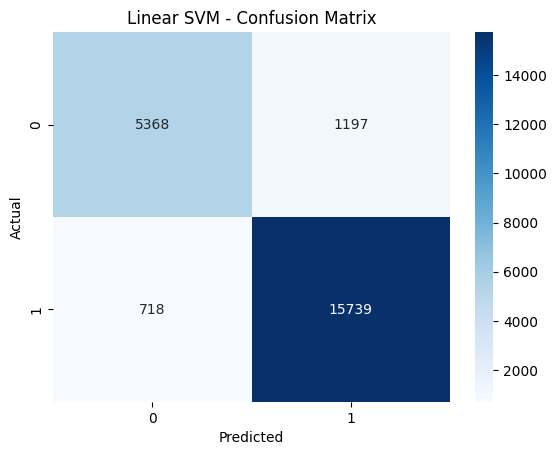

In [22]:
# Linear SVM
svm = LinearSVC()
svm.fit(X_train, y_train)
evaluate_model(svm, X_test, y_test, "Linear SVM")


📊 XGBoost Results:

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      6565
           1       0.91      0.96      0.94     16457

    accuracy                           0.91     23022
   macro avg       0.90      0.86      0.88     23022
weighted avg       0.91      0.91      0.90     23022



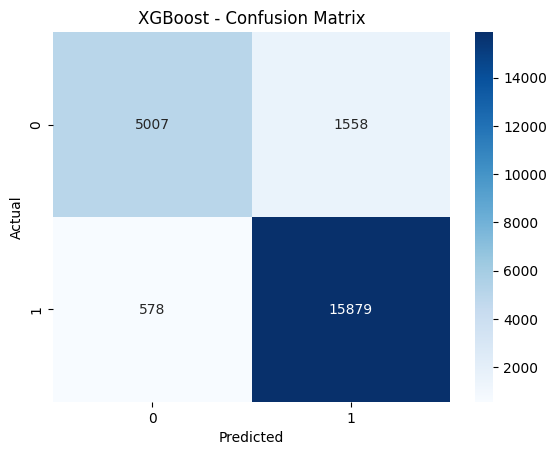

In [23]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test, "XGBoost")



📊 Random Forest Results:

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6565
           1       0.94      0.94      0.94     16457

    accuracy                           0.91     23022
   macro avg       0.90      0.89      0.90     23022
weighted avg       0.91      0.91      0.91     23022



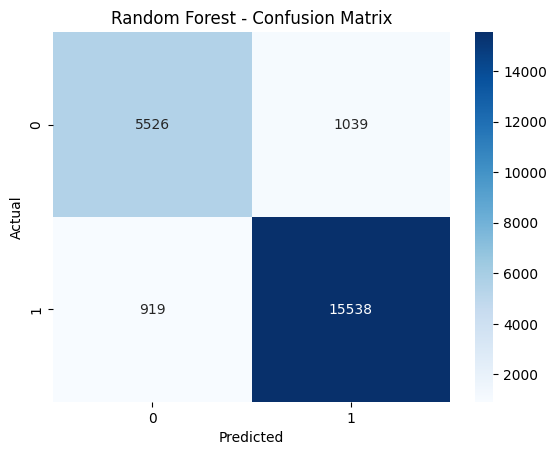

In [26]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest")